In [ ]:
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

## Import a Cassiopeia tree

import tree

In [6]:
from ete3 import Tree
import numpy as np

#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/lg7_tree_hybrid_priors.alleleThresh.collapsed.tree"
#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/3508_Apc_T1_tree.processed.tree"
tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/3726_NT_T1_tree.processed.collapsed.tree"

with open(tree_name, "r") as myfile:
    tree_string = myfile.readlines()
    tree = Tree(tree_string[0], 1)

tree = Tree(tree_name, 1)

## Sampling from a Poisson distribution

$\Sigma$ the covariance matrix is derived from the Cassioepia reconstructed phylogenetic tree. A gaussian latent vector can be sampled

$$
z \sim \mathcal{N}(0, \Sigma)
$$

Here we assume that the canonical parameter $\theta$ is given by a linear mapping of the latent vector such that:
$\forall$ i

$$
\theta_i = W z_i + \beta  
$$

and the mean of the poisson distribution if given by the link function

$$
\mu_i = exp (\theta_i)
$$

The gene expression level is drawn from the poisson distribution:

$$
x_i|z_i ~ Poisson(\mu_i)
$$

In [21]:
os.chdir('/Users/khalilouardini/Desktop/projects/scVI/scvi')

import numpy as np
import pandas as pd
from anndata import AnnData
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
from dataset.tree import TreeDataset, GeneExpressionDataset
from dataset.poisson_glm import Poisson_GLM
from dataset.anndataset import AnnDatasetFromAnnData
from models import *;
import scanpy as sc
from inference.tree_inference import TreeTrainer
from inference.inference import UnsupervisedTrainer
from inference import posterior
from models.treevae import TreeVAE
from utils.data_util import get_leaves, get_internal
from ete3 import Tree
from utils.plots_util import plot_contour_dist, plot_common_ancestor, plot_density
import logging

os.chdir('/Users/khalilouardini/Desktop/projects/scVI/scvi/notebooks')

### Visualizing the latent space dimension = 2

In [18]:
d = 2
g = 100
vis = False
leaves_only = False
var = 1.0

glm = Poisson_GLM(tree, g, d, vis, leaves_only, var)
glm.simulate_latent()

***Contour Plots***

Simulated data

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'stat_func'
  **contour_kws,
//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


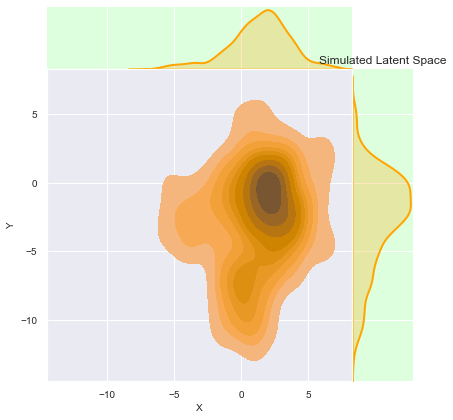

In [19]:
plot_contour_dist(glm.z, 'orange')

N(0, 1) data

//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'stat_func'
  **contour_kws,
//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
//anaconda3/envs/berkeley/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


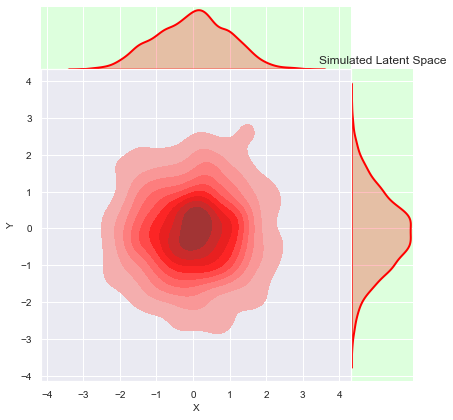

In [20]:
normal_z = np.random.randn(glm.z.shape[0], d)
plot_contour_dist(normal_z, 'red')

***Correlation Matrix***

<AxesSubplot:>

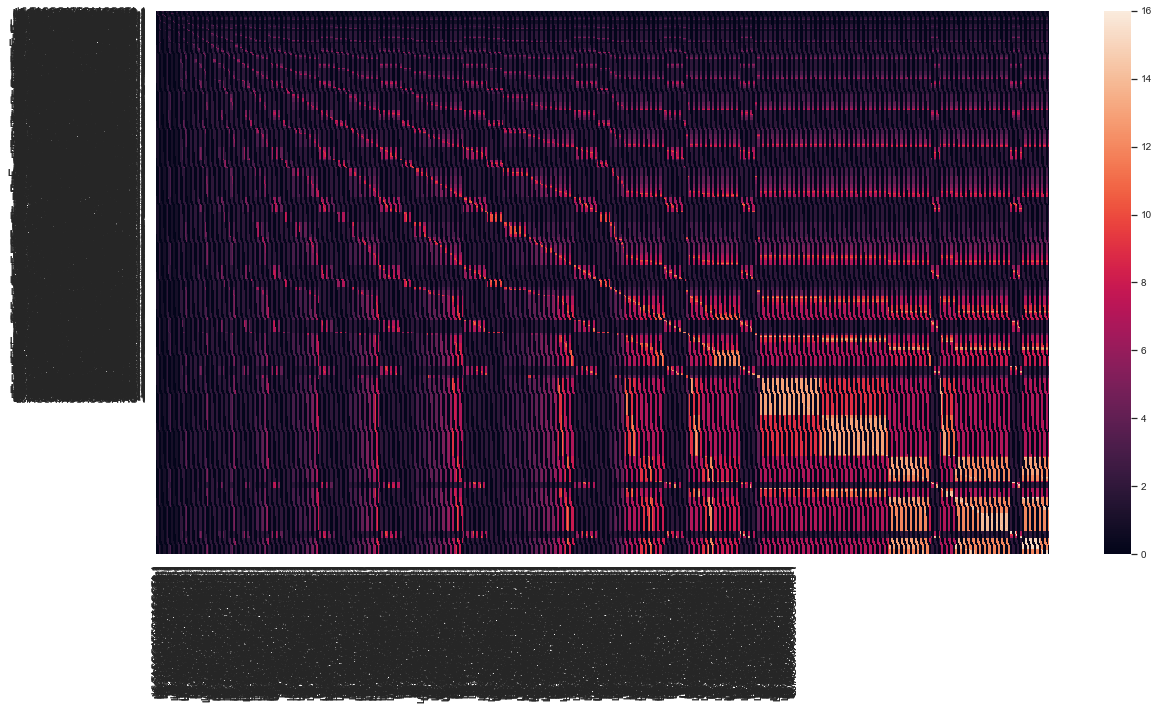

In [22]:
# plot the heatmap
n_names = np.array([[n.name]*d for n in tree]).flatten()
sns.heatmap(glm.covariance, 
            xticklabels=n_names,
            yticklabels=n_names
           )

***Latent space in higher dimension***

In [28]:
d = 10
g = 1000
vis = False
leaves_only = False
var = 1.0

glm = Poisson_GLM(tree, g, d, vis, leaves_only, var)
glm.simulate_latent()
glm.simulate_ge()

In [29]:
from scvi.dataset.tree import TreeDataset
from scvi.dataset.anndataset import AnnDatasetFromAnnData
from scvi.models.treevae import TreeVAE

In [30]:
#FIXED training set
leaves_X, leaves_idx, mu = get_leaves(glm.X, glm.mu, tree)
leaves_z, _, _ = get_leaves(glm.z, glm.mu, tree)

# internal nodes data (for imputation)
internal_X, internal_idx, internal_mu = get_internal(glm.X, glm.mu, tree)

leaves_X.shape, mu.shape, internal_X.shape, internal_mu.shape, leaves_z.shape

((772, 1000), (772, 1000), (308, 1000), (308, 1000), (772, 10))

***Visualizing embeddings of the latent space***

/Users/khalilouardini/Desktop/projects/scVI/scvi/utils/plots_util.py:339: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


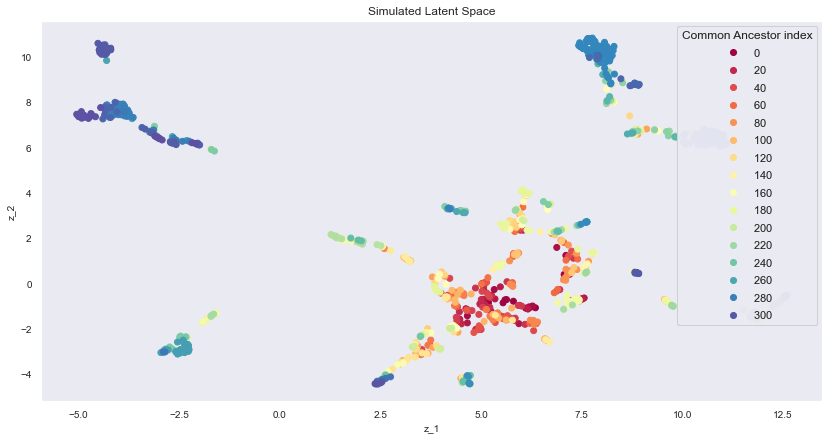

In [32]:
plot_common_ancestor(tree,
                     glm.z,
                     embedding='umap',
                     give_labels=False)

***Density of total counts***

ValueError: `dataset` input should have multiple elements.

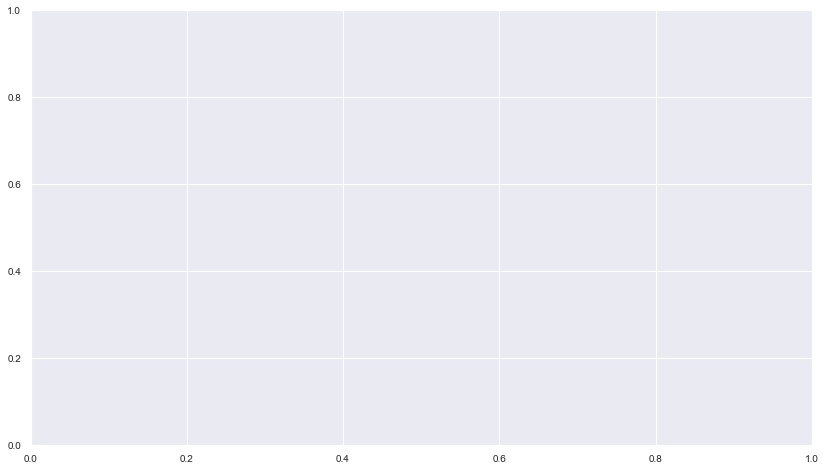

In [33]:
plot_density(glm.X)

***Likelihood Ratio Test***

***CascVI***

In [232]:
# Open File
file = open("barcodes.tsv",'w')

# Write data to file
for row in tree.get_leaves():
    file.write(row.name + "\n")
file.close()

# anndata
adata = AnnData(leaves_X)
scvi_dataset = AnnDatasetFromAnnData(adata)
adata.obs_names = pd.read_csv('barcodes.tsv', header=None)[0]
scvi_dataset.initialize_cell_attribute('barcodes', adata.obs_names)
barcodes = [l.name for l in tree.get_leaves()]

# treeVAE
cas_dataset = TreeDataset(scvi_dataset, tree = tree_name)
cas_dataset

[2021-03-15 23:35:24,504] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-03-15 23:35:24,505] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-03-15 23:35:24,526] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-03-15 23:35:24,528] INFO - scvi.dataset.dataset | Downsampled from 772 to 772 cells


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([64, 65], dtype='int64'), …


[2021-03-15 23:35:25,451] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2021-03-15 23:35:25,452] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2021-03-15 23:35:25,454] INFO - scvi.dataset.dataset | Keeping 1000 genes
[2021-03-15 23:35:25,469] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-03-15 23:35:25,471] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-03-15 23:35:25,472] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-03-15 23:35:25,474] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-03-15 23:35:25,475] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-03-15 23:35:25,492] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-03-15 23:35:25,493] INFO - scvi.dataset.dataset | Downsampled from 772 to 772 cells


GeneExpressionDataset object with n_cells x nb_genes = 772 x 1000
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_vars', 'labels', 'barcodes', 'local_means', 'batch_indices'
    cell_categorical_attribute_names: 'batch_indices', 'labels'

In [233]:
n_epochs = 1000
lr = 1e-4
# No batches beacause of the message passing
use_batches = False
use_cuda = False

treevae = TreeVAE(cas_dataset.nb_genes, tree = cas_dataset.tree, n_batch=cas_dataset.n_batches * use_batches,
                  n_latent=glm.latent, n_hidden=128, n_layers=1)

***Likelihood of N(0, 1) data***

In [227]:
treevae.initialize_visit()
treevae.initialize_messages(np.random.randn(leaves_z.shape[0], d), barcodes, d)
treevae.perform_message_passing((treevae.tree & treevae.root), d, False)

mp_lik = treevae.aggregate_messages_into_leaves_likelihood(d, add_prior=True)
print(mp_lik)

-8928.413534961668


***Likelihood of observations***

In [1]:
treevae.initialize_visit()
treevae.initialize_messages(leaves_z, barcodes, d)
treevae.perform_message_passing((treevae.tree & treevae.root), d, False)

mp_lik = treevae.aggregate_messages_into_leaves_likelihood(d, add_prior=True)
print(mp_lik)

NameError: name 'treevae' is not defined

In [27]:
#Richard's tree
#import pickle 
#import ete3

#tree_file = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/1000cells/no_fitness/topology20.pkl"

#with open(tree_file, 'rb') as f:
    #graph = pickle.load(f)

# adding branch length attribute to the leaves
#for n in graph.nodes(data=True):
    #if type(n[0]) == int:
        #n[1]['branch_length'] = 0
    #else:
        #n[1]['branch_length'] = n[0].branch_length
        
#def networkx_to_ete3(graph, root):
    #subtrees = {node[0]: ete3.Tree(name=node[0], dist=node[1]['branch_length']) for node in graph.nodes(data=True)}
    #[*map(lambda edge: subtrees[edge[0]].add_child(subtrees[edge[1]]), graph.edges())]
    #tree = subtrees[root]
    #return tree

#branch_lengths = {}

#root = [n for n, d in graph.in_degree() if d==0] [0]
#tree = networkx_to_ete3(graph, root)

#for i, n in enumerate(tree.traverse('levelorder')):
    #n.add_features(index=i)
    #n.name = str(i)
    #branch_lengths[n.name] = n.dist
    
#tree